## Importing libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import esda
import pysal
import libpysal as lps
from splot import esda as esdaplot


module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-02-24 17:55:09 Configured OSMnx 1.1.1
2023-02-24 17:55:09 HTTP response caching is on


## Downloading data

GDL Public transport routes

<AxesSubplot:>

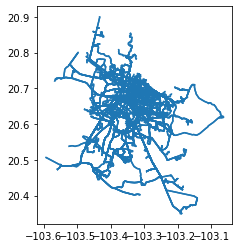

In [3]:
routes_gdl  = gpd.read_file("../../data/external/db_segundopiso_temp/rutastransporte_gdl.gpkg")
routes_gdl.plot()

hex in buffer 2km LM data

<AxesSubplot:>

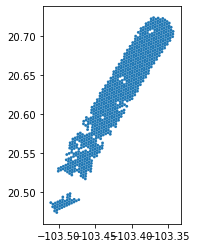

In [4]:
hex_2km = aup.gdf_from_db('censo1020_mza_hexres9_buffer2km','segundopiso')
hex_2km.plot()

## Spatial join

hex info to public transport routes

In [5]:
routes_hexid = routes_gdl.overlay(hex_2km)
print(routes_hexid.shape)
routes_hexid.head(2)

(4186, 442)


,Tipo_de_se,Clasificac,Clasifica0,hex_id_9,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,...,Chng_RVivHab_10,DensPob_10_20,city,ubicacion,viv_serv,10_viv_serv,%vivconauto,10_%vivconauto,chg_%vivconauto_10_20,geometry
0,Complementaria,Rutas complementarias y otros servicios,Operando,89498c96a47ffff,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,-0.323395,Guadalajara,Norte del periferico,0.0,0.0,NaN,NaN,NaN,"LINESTRING (-103.34681 20.69315, -103.34684 20..."
1,Complementaria,Rutas complementarias y otros servicios,Operando,89498c96a47ffff,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,-0.323395,Guadalajara,Norte del periferico,0.0,0.0,NaN,NaN,NaN,"LINESTRING (-103.34681 20.69315, -103.34684 20..."


Grouping by hex and counting

In [6]:
routes_hexid_sum = routes_hexid.groupby('hex_id_9').count()
routes_hexid_sum = routes_hexid_sum.reset_index().rename(columns={'pobtot':'routes_count'})
routes_hexid_sum = routes_hexid_sum[['hex_id_9','routes_count']].copy()

print(routes_hexid_sum.shape)
routes_hexid_sum.head(2)

(489, 2)


,hex_id_9,routes_count
0,89498c941a7ffff,8
1,89498c941b7ffff,2


Joining with geometry layer

In [7]:
routes_hex9 = hex_2km.merge(routes_hexid_sum, on='hex_id_9', how='left')
print(routes_hex9.shape)
routes_hex9.head(1)

(853, 440)


,hex_id_9,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,...,DensPob_10_20,city,ubicacion,geometry,viv_serv,10_viv_serv,%vivconauto,10_%vivconauto,chg_%vivconauto_10_20,routes_count
0,89498c96ddbffff,579.0,313.0,266.0,3.0,0.0,0.0,571.0,309.0,262.0,...,-2.263532,Guadalajara,Norte del periferico,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",188.0,184.0,87.765957,89.130435,-1.364477,NaN


## Data treatment

In [9]:
fields_tokeep = ['hex_id_9','geometry','ubicacion','routes_count']
routes_hex9f = routes_hex9[fields_tokeep]
routes_hex9f.head()

,hex_id_9,geometry,ubicacion,routes_count
0,89498c96ddbffff,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",Norte del periferico,NaN
1,89498c96dafffff,"POLYGON ((-103.40935 20.67232, -103.40814 20.6...",Norte del periferico,2.0
2,89498c94ca7ffff,"POLYGON ((-103.36383 20.71493, -103.36261 20.7...",Norte del periferico,2.0
3,8949ab59527ffff,"POLYGON ((-103.43663 20.62134, -103.43541 20.6...",Sur del periferico,2.0
4,89498c96c13ffff,"POLYGON ((-103.37956 20.65270, -103.37834 20.6...",Norte del periferico,10.0


In [12]:
idx = routes_hex9f['routes_count'].isna()
routes_hex9f.loc[idx,'routes_count'] = 0
routes_hex9f.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,hex_id_9,geometry,ubicacion,routes_count
0,89498c96ddbffff,"POLYGON ((-103.39147 20.66055, -103.39026 20.6...",Norte del periferico,0.0
1,89498c96dafffff,"POLYGON ((-103.40935 20.67232, -103.40814 20.6...",Norte del periferico,2.0
2,89498c94ca7ffff,"POLYGON ((-103.36383 20.71493, -103.36261 20.7...",Norte del periferico,2.0
3,8949ab59527ffff,"POLYGON ((-103.43663 20.62134, -103.43541 20.6...",Sur del periferico,2.0
4,89498c96c13ffff,"POLYGON ((-103.37956 20.65270, -103.37834 20.6...",Norte del periferico,10.0


## Data analysis

In [16]:
zone_routesavg = routes_hex9f.groupby('ubicacion').agg({'routes_count':np.average})
zone_routesavg

,routes_count
ubicacion,
Norte del periferico,6.043573
Sur del periferico,3.583756


## Saving to db

In [17]:
aup.gdf_to_db_slow(routes_hex9f,'rutastransporte_2km_hex9','segundopiso',if_exists="replace")